In [1]:
%env HSA_OVERRIDE_GFX_VERSION=10.3.0
%env ROCM_PATH=/opt/rocm
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["AUTOGRAPH_VERBOSITY"] = "0"

env: HSA_OVERRIDE_GFX_VERSION=10.3.0
env: ROCM_PATH=/opt/rocm


In [2]:
from IPython.display import display
from ipyfilechooser import FileChooser
import configparser

# Loading configurations
configParser = configparser.RawConfigParser()   
configFilePath = r'configuration.txt'
configParser.read(configFilePath)

use_video_in_configuration =  int(configParser.get('fineTuneStableDiffusionTesting', 
                                                   'use_video_in_configuration'))

video_path =  configParser.get('fineTuneStableDiffusionTesting', 
                                                   'video_path')

ttwbdf =  int(configParser.get('fineTuneStableDiffusionTesting', 'time_to_wait_before_deleting_files'))


dev_mode =  int(configParser.get('fineTuneStableDiffusionTesting', 'dev_mode'))

cuda =  int(configParser.get('COMMON', 'cuda'))
cpus =  int(configParser.get('COMMON', 'cpus'))


if(use_video_in_configuration == 0):
    fc = FileChooser('/')
    


    # Create and display a FileChooser widget

    # Set a file filter patern
    fc.filter_pattern = '*.mp4'
    display(fc)

    # Print the selected filename
    print(fc.selected_filename)


In [3]:
if(use_video_in_configuration == 0):
    video_path = fc.selected

In [4]:
gender_dict = {
  3: "",
  1: "This person is a man. ",
  2: "This person is a woman. "
}

genderChoice = 0

if(dev_mode != 0):
    genderChoice = 1

while genderChoice < 1 or genderChoice > 3:
    try:
        genderChoice = int(input("Please choose a gender 1(man), 2(woman) and 3(unspecified) > "))
    except ValueError:
        print('We expect you to enter a valid integer')




In [5]:
import json
language_dict_temp = json.load(open("language.dict"))
language_dict = dict((v,k) for k,v in language_dict_temp.items())

languageChoice = -1

if(dev_mode != 0):
    languageChoice = 8

while languageChoice < 0 or languageChoice > 45:
    try:
        languageChoice = int(input("Please choose a language " + str(language_dict)))
    except ValueError:
        print('We expect you to enter a valid integer')

for key in language_dict:
    language_dict[key] = 'This person speaks ' + language_dict[key] + ". "
language_dict[45] = ""



In [6]:
language_dict[languageChoice]

''

In [7]:
#TODO document jupyter
import pickle
import sqlite3 as sl
import pandas as pd
import numpy as np
from PIL import Image

from textwrap import wrap
import os

import keras_cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.experimental.numpy as tnp
from keras_cv.models.stable_diffusion.clip_tokenizer import SimpleTokenizer
from keras_cv.models.stable_diffusion.diffusion_model import DiffusionModel
from keras_cv.models.stable_diffusion.image_encoder import ImageEncoder
from keras_cv.models.stable_diffusion.noise_scheduler import NoiseScheduler
from keras_cv.models.stable_diffusion.text_encoder import TextEncoder
from tensorflow import keras
import multiprocessing


You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.
You do not have pyococotools installed, so the `PyCOCOCallback` API is not available.
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.


In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None


In [10]:
print("Number of cpus to use for multiprocessing : ", cpus)
if(cuda == 0):
    print("Not using cuda")
else:
    print("Will try to use cuda, if no cuda is present please set cuda = 0 in configuration.txt")

Number of cpus to use for multiprocessing :  8
Not using cuda


In [11]:
audio_folder = output_folder = r'fineTuneStableDiffusionTestingFolder' 
if not os.path.exists(audio_folder):
    os.makedirs(audio_folder)

In [12]:
weights_path = "finetuned_stable_diffusion.h5"
img_height = img_width = 128
s2f_model = keras_cv.models.StableDiffusion(
    img_width=img_width, img_height=img_height
)
# We just reload the weights of the fine-tuned diffusion model.
#s2f_model.diffusion_model.save_weights(weights_path)


By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


In [13]:
s2f_model.diffusion_model.load_weights(weights_path)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [14]:
def plot_images(images, title, audio_length):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])

        #print(images[i])

        img = Image.fromarray(images[i], 'RGB')
        img.save(output_folder + '/' + str(audio_length) + '.png')
        
        plt.title(title + ' (audio length=' + str(audio_length) + ')', 
                  fontsize=12)
        plt.axis("off")

In [15]:
def convertS2F(embeddings,audio_length):
    embeddings = embeddings.cpu().detach().numpy()
    speaker_emb2 = embeddings.squeeze()
    speaker_emb2 = np.pad(speaker_emb2, (288), 'constant', constant_values=(0))

    prompt = "The face of a person. " + gender_dict[genderChoice] #"Hello Kitty", "A pokemon with red eyes"]
    #prompts = ["Yoda", "Hello Kitty", "A pokemon with red eyes"]
    images_to_generate = 3
    outputs = {}
    encoded_text = s2f_model.encode_text(prompt)

    encoded_text = encoded_text[:,:-1,:]

    speaker_emb2 = np.tile(speaker_emb2, (1, 1))
    speaker_emb3 = np.tile(speaker_emb2, (1, 1))

    emb = np.expand_dims(speaker_emb2, axis=1)

    encoded_text = np.concatenate((encoded_text, emb), axis=1)

    generated_images = s2f_model.generate_image(
        encoded_text = encoded_text, batch_size=images_to_generate, unconditional_guidance_scale=40
    )
    outputs.update({prompt: generated_images})

    for prompt in outputs:
        plot_images(outputs[prompt], prompt, audio_length)
    
    





In [16]:
import torchaudio
import speechbrain as sb
from speechbrain.pretrained import EncoderClassifier

if(cuda == 0):
    classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb")
else:
    classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb",run_opts={"device":"cuda"})

In [17]:


video_filename = os.path.basename(video_path)

In [18]:
absPathAudio_w = os.path.abspath(audio_folder) + "/" + video_filename
absPathAudio = os.path.splitext(absPathAudio_w)[0]+'_audio.wav'
absPathAudio_w = os.path.splitext(absPathAudio_w)[0]
absPathAudio

'/home/gamal/vsc/DiffusionSpeech2Face/fineTuneStableDiffusionTestingFolder/blhA_I4zjvE_15.600000_22.333333_audio.wav'

In [19]:
import subprocess
# Extract audio monochannel and with 16khz and put it in absPathAudio

command = "ffmpeg -nostats -loglevel 0 -y -i '" + video_path + "' -acodec pcm_s16le -ab 160k -ac 1 -ar 16000 -vn '" + absPathAudio  + "'"
subprocess.call(command, shell=True)

0

In [20]:
from pydub import AudioSegment
import math
# Get original duration of video
audio = AudioSegment.from_file(video_path)
audio_length_og = math.floor(audio.duration_seconds)
audio_length_og

6

/home/gamal/anaconda3/envs/ds2f_m_i/lib/python3.8/site-packages/torch/functional.py:641: UserWarning: stft with return_complex=False is deprecated. In a future pytorch release, stft will return complex tensors for all inputs, and return_complex=False will raise an error.
Note: you can still call torch.view_as_real on the complex output to recover the old return format. (Triggered internally at ../aten/src/ATen/native/SpectralOps.cpp:862.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore[attr-defined]


50/50 [==============================] - 35s 593ms/step


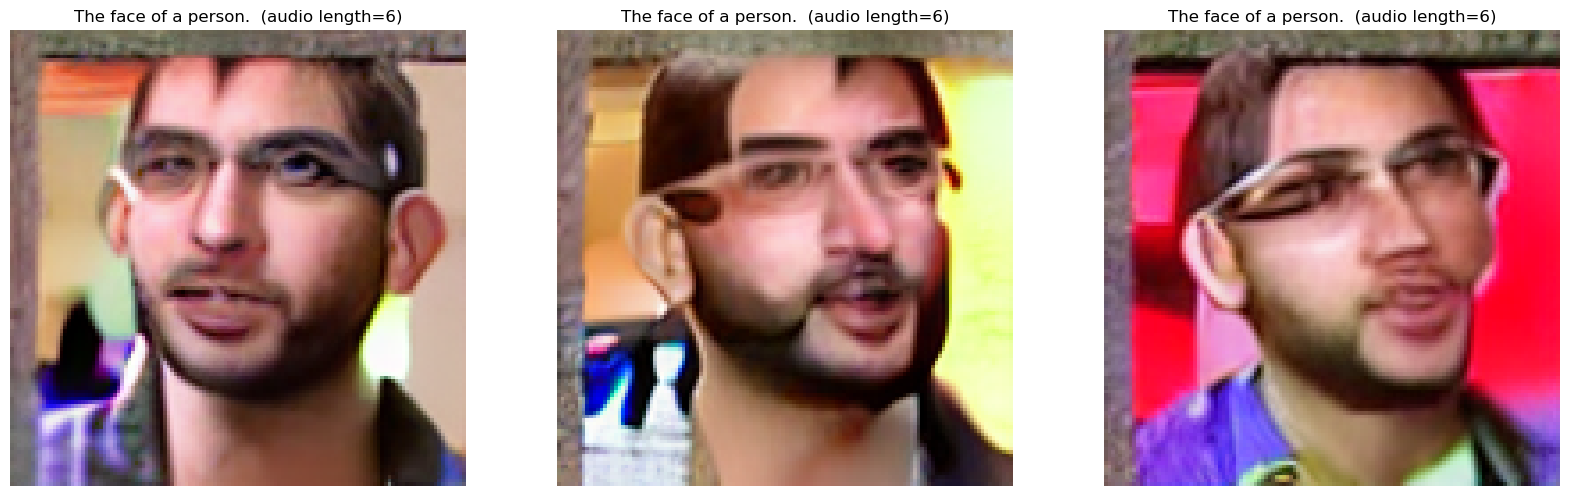

In [21]:
import torchaudio
from threading import Thread
import time


# Function to delete audio temp files
def delFiles(filesToDelete):
    time.sleep(ttwbdf)  # wait a bit
    for file in filesToDelete:  
        try:
            os.remove(file)
        except OSError:
            pass


# Will either truncate or loop the original video to reach audio_length (6,12 or 24)
audio_length_list = [6]
for audio_length in audio_length_list:
    path_var_len_audio =  absPathAudio_w + "audio" + str(audio_length) + "s.wav"    # path to the variable length audio
    path_var_len_audio_temp =  absPathAudio_w + "audio_temp" + str(audio_length) + "s.wav"  # path to a temp version of the variable length audio

    if(audio_length_og > audio_length):
        # Truncate    

        command = "ffmpeg -nostats -loglevel 0 -y -ss 0 -t "+str(audio_length)+" -i \"" + absPathAudio + "\" \"" + path_var_len_audio + "\""
        subprocess.call(command, shell=True)


    else:
        # Loop then truncaate
        #print("lesa")
        twoDigitLenStr = f"{audio_length:02}"
        #print(twoDigitLenStr)
        command = "ffmpeg -nostats -loglevel 0 -y -stream_loop -1 -i '" + absPathAudio + "' -t \"00:00:"+twoDigitLenStr+".000\" -codec:a \"aac\" -f \"wav\" -c copy '"+ path_var_len_audio_temp + "'"
        subprocess.call(command, shell=True)
        command = "ffmpeg -nostats -loglevel 0 -y -ss 0 -t "+str(audio_length)+" -i \"" + path_var_len_audio_temp + "\" \"" + path_var_len_audio + "\""
        subprocess.call(command, shell=True)

    # Extract speaker embeddings
    signal, fs = torchaudio.load(path_var_len_audio)
    embeddings = classifier.encode_batch(signal)
    

    convertS2F(embeddings,audio_length)

    ftd = [absPathAudio,path_var_len_audio,os.path.basename(path_var_len_audio),path_var_len_audio_temp]
    tDelete = Thread(target=delFiles, args=(ftd,))   # spawn a process
    tDelete.start()



In [ ]:
import os
os._exit(0)

: 

: 